### Importing Necessary Libraries

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from scipy.optimize import minimize
import matplotlib.pyplot as plt

yf.pdr_override()
%matplotlib inline

### Getting Trading Data

In [2]:
tickers = ['META', 'AMZN', 'MSFT', 'AAPL', 'GOOG', 'GOOGL', 'TSLA']
data = pd.DataFrame()

for t in tickers:
    data[t] = pdr.get_data_yahoo(t, start='2015-1-1')['Adj Close']
data.tail(10) # Showing the adjusted close prices from the last 10 trading days

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,META,AMZN,MSFT,AAPL,GOOG,GOOGL,TSLA
Date,,,,,,,
2023-07-17,310.619995,133.559998,345.730011,193.990005,125.059998,124.650002,290.380005
2023-07-18,312.049988,132.830002,359.489990,193.729996,124.080002,123.760002,293.339996
2023-07-19,316.010010,135.360001,355.079987,195.100006,122.779999,122.029999,291.260010
2023-07-20,302.519989,129.960007,346.869995,193.130005,119.529999,119.199997,262.899994
2023-07-21,294.260010,130.000000,343.769989,191.940002,120.309998,120.019997,260.019989
2023-07-24,291.609985,128.800003,345.109985,192.750000,121.879997,121.529999,269.059998
2023-07-25,294.470001,129.130005,350.980011,193.619995,122.790001,122.209999,265.279999
2023-07-26,298.570007,128.149994,337.769989,194.500000,129.660004,129.270004,264.350006
2023-07-27,311.709991,128.250000,330.720001,193.220001,129.869995,129.399994,255.710007


<Axes: xlabel='Date'>

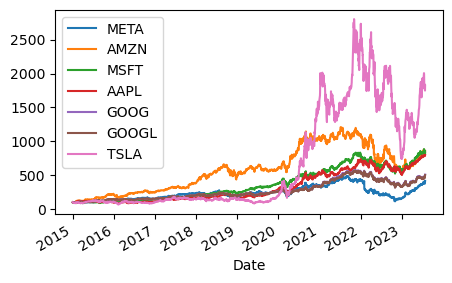

In [3]:
(data / data.iloc[0] * 100).plot(figsize=(5, 3)) # Normalizing price data to compare performance between the stocks

### Plotting Portfolio Set

Text(0, 0.5, 'Expected Return')

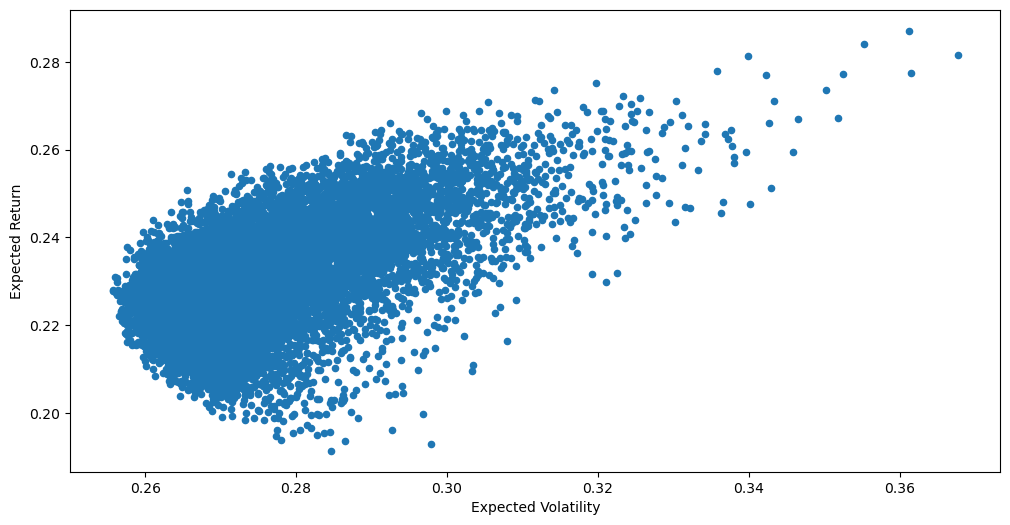

In [4]:
log_returns = np.log(data / data.shift(1))
trading_days = 252

portret = []
portvol = []

for x in range (10000): # Considering 10,000 possible combinations of the portfolio
    weight = np.random.random(len(tickers))
    weight /= np.sum(weight)
    portret.append(np.sum(weight * log_returns.mean()) * trading_days)
    portvol.append(np.sqrt(np.dot(weight.T, np.dot(log_returns.cov() * trading_days, weight))))

portret = np.array(portret)
portvol = np.array(portvol)

portfolios = pd.DataFrame({'Return': portret, 'Volatility': portvol})
portfolios.plot(x='Volatility', y='Return', kind='scatter', figsize=(12, 6));
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')

### Determining Optimal Share Allocation

In [5]:
initial_shares = 1000 # How to allocate 1,000 shares between the given basket of stocks 'Tickers'
riskfree_rate = 0.025
covariances = log_returns.cov() * trading_days

def expected_returns (weights, log_returns):
    return np.sum(log_returns.mean() * weights) * trading_days
def stdev (weights, covariances):
    variance = weights.T @ covariances @ weights
    return np.sqrt(variance)
def sharpe (weights, log_returns, covariances, riskfree_rate):
    return (expected_returns (weights, log_returns) - riskfree_rate) / stdev (weights, covariances)
def neg_sharpe (weights, log_returns, covariances, riskfree_rate):
    return - sharpe (weights, log_returns, covariances, riskfree_rate)

cons = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bnds = [(0, 0.5) for _ in range(len(tickers))]

initial_weights = np.array([1 / len(tickers)] * len(tickers))

optimized_soln = minimize(neg_sharpe, initial_weights, args = (log_returns, covariances, riskfree_rate), method='SLSQP', constraints=cons, bounds=bnds)
optimal_weights = np.around(optimized_soln.x * initial_shares, decimals = 0, out = None)

result = pd.DataFrame({'Tickers': tickers, 'Optimal Share Allocation': optimal_weights}).set_index('Tickers')
result

,Optimal Share Allocation
Tickers,
META,0.0
AMZN,166.0
MSFT,444.0
AAPL,284.0
GOOG,0.0
GOOGL,0.0
TSLA,106.0


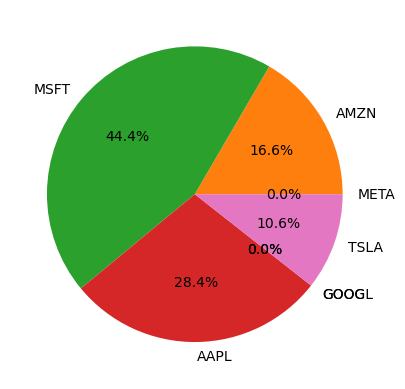

In [6]:
plt.pie(optimal_weights, labels = tickers, autopct='%1.1f%%')
plt.show()